In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate



In [2]:
def create_lag_df(yf_name):   #input as string
    stock = yf.Ticker(yf_name)
    df = stock.history('6mo')
    df_exp = df[['Close']]
    # print(df_exp)

    for i in range(1,30+1):
        df_exp[f'Close_lag{i}d'] = df_exp['Close'].shift(i) #next i day
    df_exp = df_exp.dropna()
    # print(df_exp)
    return df_exp

#col to remove
def remove_col(lag_df, days_no):
    col_to_remove = []
    for i in range(1,days_no+1):
        col_to_remove.append(f"Close_lag{i}d")
    df_dropped = lag_df.drop(col_to_remove, axis=1)
    return df_dropped

def create_label_feature_df(df_dropped):
    df_features = df_dropped.drop('Close', axis=1)
    df_label = pd.DataFrame(df_dropped['Close'])
    return df_features, df_label

def split(df_features, df_label, test_size):
    row_no = df_features.shape[0]
    train_row_no = round(row_no*(1.0-test_size))
    print(row_no)

    X_train = df_features.iloc[:train_row_no, :]
    X_test  = df_features.iloc[train_row_no:row_no, :]
    y_train = df_label.iloc[:train_row_no, :]
    y_test  = df_label.iloc[train_row_no:row_no, :]
    return X_train, X_test, y_train, y_test

# yf_name = "AAPL"
# yf_name = "^GSPC"
yf_name = "BTC-USD"
# yf_name = "AXON"
#feature for training
lag_df = create_lag_df(yf_name)
df_dropped = remove_col(lag_df,7)
X, y = create_label_feature_df(df_dropped)
X_train, X_test, y_train, y_test = split(X, y,0.2)
date_df = lag_df.index
lag_df

153


C:\Users\Norapath Arjanurak\AppData\Local\Temp\ipykernel_20868\3036575753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp[f'Close_lag{i}d'] = df_exp['Close'].shift(i) #next i day
C:\Users\Norapath Arjanurak\AppData\Local\Temp\ipykernel_20868\3036575753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp[f'Close_lag{i}d'] = df_exp['Close'].shift(i) #next i day
C:\Users\Norapath Arjanurak\AppData\Local\Temp\ipykernel_20868\3036575753.py:8: SettingWithCopyWarning: 
A value is trying to be set

,Close,Close_lag1d,Close_lag2d,Close_lag3d,Close_lag4d,Close_lag5d,Close_lag6d,Close_lag7d,Close_lag8d,Close_lag9d,...,Close_lag21d,Close_lag22d,Close_lag23d,Close_lag24d,Close_lag25d,Close_lag26d,Close_lag27d,Close_lag28d,Close_lag29d,Close_lag30d
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-16 00:00:00+00:00,65097.148438,64870.152344,60787.792969,59231.953125,57899.464844,57344.914062,57742.496094,58009.226562,56705.097656,55849.109375,...,61804.640625,60277.414062,63180.796875,64252.578125,64096.199219,64828.656250,64960.296875,65140.746094,66490.296875,66639.046875
2024-07-17 00:00:00+00:00,64118.792969,65097.148438,64870.152344,60787.792969,59231.953125,57899.464844,57344.914062,57742.496094,58009.226562,56705.097656,...,60811.277344,61804.640625,60277.414062,63180.796875,64252.578125,64096.199219,64828.656250,64960.296875,65140.746094,66490.296875
2024-07-18 00:00:00+00:00,63974.066406,64118.792969,65097.148438,64870.152344,60787.792969,59231.953125,57899.464844,57344.914062,57742.496094,58009.226562,...,61604.800781,60811.277344,61804.640625,60277.414062,63180.796875,64252.578125,64096.199219,64828.656250,64960.296875,65140.746094
2024-07-19 00:00:00+00:00,66710.156250,63974.066406,64118.792969,65097.148438,64870.152344,60787.792969,59231.953125,57899.464844,57344.914062,57742.496094,...,60320.136719,61604.800781,60811.277344,61804.640625,60277.414062,63180.796875,64252.578125,64096.199219,64828.656250,64960.296875
2024-07-20 00:00:00+00:00,67163.648438,66710.156250,63974.066406,64118.792969,65097.148438,64870.152344,60787.792969,59231.953125,57899.464844,57344.914062,...,60887.378906,60320.136719,61604.800781,60811.277344,61804.640625,60277.414062,63180.796875,64252.578125,64096.199219,64828.656250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-11 00:00:00+00:00,101173.031250,96675.429688,97432.718750,101236.015625,99923.335938,99920.710938,96593.570312,98768.531250,96002.164062,95865.304688,...,94339.492188,92343.789062,90542.640625,89845.851562,90558.476562,91066.007812,87250.429688,90584.164062,87955.812500,88701.484375
2024-12-12 00:00:00+00:00,100043.000000,101173.031250,96675.429688,97432.718750,101236.015625,99923.335938,99920.710938,96593.570312,98768.531250,96002.164062,...,98504.726562,94339.492188,92343.789062,90542.640625,89845.851562,90558.476562,91066.007812,87250.429688,90584.164062,87955.812500
2024-12-13 00:00:00+00:00,101459.257812,100043.000000,101173.031250,96675.429688,97432.718750,101236.015625,99923.335938,99920.710938,96593.570312,98768.531250,...,98997.664062,98504.726562,94339.492188,92343.789062,90542.640625,89845.851562,90558.476562,91066.007812,87250.429688,90584.164062


In [3]:
print(X.shape)
print(y.shape)

(153, 23)
(153, 1)


In [4]:
# Split data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [5]:
# Decision Tree Regression
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)  # Adjust max_depth for complexity
tree_model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5, random_state=42)

In [6]:
# Predictions
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)


In [7]:
# Evaluate
print("Training MSE:", mean_squared_error(y_train, y_pred_train))
print("Testing MSE:", mean_squared_error(y_test, y_pred_test))
print("Training R2:", r2_score(y_train, y_pred_train))
print("Testing R2:", r2_score(y_test, y_pred_test))


Training MSE: 5463264.370807085
Testing MSE: 90522162.3706921
Training R2: 0.8787335309863803
Testing R2: -5.828622246541651


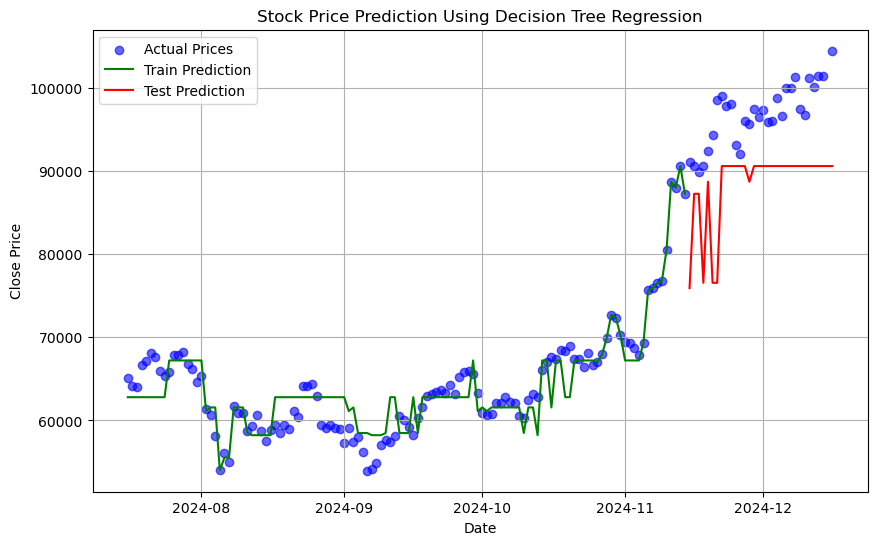

In [8]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(date_df, y, label='Actual Prices', color='blue', alpha=0.6)
plt.plot(date_df[:split_index], y_pred_train, label='Train Prediction', color='green')
plt.plot(date_df[split_index:], y_pred_test, label='Test Prediction', color='red')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Prediction Using Decision Tree Regression")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from sklearn.model_selection import cross_val_score, train_test_split, ParameterGrid, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np

Hyperparameter tuning

In [10]:
# Initialize models and hyperparameter ranges for regression
models = {
    'LinearRegression': (LinearRegression(), {}),
    'DecisionTreeRegressor': (DecisionTreeRegressor(random_state=42), {'max_depth': [None, 5, 10, 15]}),
    'RandomForestRegressor': (RandomForestRegressor(random_state=42), {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10, 15]}),
    'SVR': (SVR(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
}

model_results = {}
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define scoring metrics
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']


# Perform k-fold cross-validation for each model
for name, (model, params) in models.items():
    print(f"\nEvaluating Model: {name}")
    
    best_mean_cv_mse = float('inf')  # Lower is better for MSE
    best_mean_cv_mae = float('inf')
    best_mean_cv_r2 = float('-inf')  # Higher is better for R2
    best_predictions = None
    best_params = None
    
    # Loop over each hyperparameter combination
    for param_combination in ParameterGrid(params):
        # Set parameters for the current model
        model.set_params(**param_combination)
        
        # Create a pipeline with a StandardScaler and the model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Perform cross-validation for each metric
        cv_scores = {}
        for metric in scoring_metrics:
            cv_scores[metric] = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=metric, n_jobs=-1)
            y_pred_train = cross_val_predict(pipeline, X_train, y_train, cv=kf, n_jobs=-1)
            # print(f"Prediction: {y_pred}")
            # print('End predict')
        
        # Print scores for each metric
        # for metric, scores in cv_scores.items():
        #     print(f"Parameters: {param_combination} => {metric}: {scores}")
        
        # Calculate mean scores for each metric
        mean_cv_mse = -np.mean(cv_scores['neg_mean_squared_error'])  # Convert to positive MSE
        mean_cv_mae = -np.mean(cv_scores['neg_mean_absolute_error'])  # Convert to positive MAE
        mean_cv_r2 = np.mean(cv_scores['r2'])
        
        # Update the best parameters based on MSE
        if mean_cv_mse < best_mean_cv_mse:
            best_mean_cv_mse = mean_cv_mse
            best_mean_cv_mae = mean_cv_mae
            best_mean_cv_r2 = mean_cv_r2
            best_predictions = y_pred_train
            best_params = param_combination
    
    # Save results for the model
    model_results[name] = {
        'Best Cross-Validation MSE': best_mean_cv_mse,
        'Best Cross-Validation MAE': best_mean_cv_mae,
        'Best Cross-Validation R2': best_mean_cv_r2,
        'Best Predictions train': best_predictions,
        'Best Parameters': best_params
    }
    
    print(f"Best Cross-Validation Mean MSE: {best_mean_cv_mse:.2f}")
    print(f"Best Cross-Validation Mean MAE: {best_mean_cv_mae:.2f}")
    print(f"Best Cross-Validation Mean R2: {best_mean_cv_r2:.2f}")
    print(f"Best Parameters: {best_params}")

# Determine the best models based on each metric
best_mse_model = min(model_results, key=lambda model: model_results[model]['Best Cross-Validation MSE'])
best_mae_model = min(model_results, key=lambda model: model_results[model]['Best Cross-Validation MAE'])
best_r2_model = max(model_results, key=lambda model: model_results[model]['Best Cross-Validation R2'])

# Print the best models and their metrics
print("\nBest Models for Each Metric:")
print(f"Best Model (MSE): {best_mse_model}")
print(f"Metrics: MSE={model_results[best_mse_model]['Best Cross-Validation MSE']:.4f}, Parameters: {model_results[best_mse_model]['Best Parameters']}")

print(f"\nBest Model (MAE): {best_mae_model}")
print(f"Metrics: MAE={model_results[best_mae_model]['Best Cross-Validation MAE']:.4f}, Parameters: {model_results[best_mae_model]['Best Parameters']}")

print(f"\nBest Model (R²): {best_r2_model}")
print(f"Metrics: R²={model_results[best_r2_model]['Best Cross-Validation R2']:.4f}, Parameters: {model_results[best_r2_model]['Best Parameters']}")


Evaluating Model: LinearRegression
Best Cross-Validation Mean MSE: 30414191.91
Best Cross-Validation Mean MAE: 4354.43
Best Cross-Validation Mean R2: -0.07
Best Parameters: {}

Evaluating Model: DecisionTreeRegressor
Best Cross-Validation Mean MSE: 25559286.67
Best Cross-Validation Mean MAE: 3561.31
Best Cross-Validation Mean R2: 0.27
Best Parameters: {'max_depth': 5}

Evaluating Model: RandomForestRegressor
Best Cross-Validation Mean MSE: 11920054.97
Best Cross-Validation Mean MAE: 2492.87
Best Cross-Validation Mean R2: 0.67
Best Parameters: {'max_depth': 10, 'n_estimators': 50}

Evaluating Model: SVR
Best Cross-Validation Mean MSE: 31366291.04
Best Cross-Validation Mean MAE: 4062.49
Best Cross-Validation Mean R2: 0.18
Best Parameters: {'C': 10, 'kernel': 'linear'}

Best Models for Each Metric:
Best Model (MSE): RandomForestRegressor
Metrics: MSE=11920054.9667, Parameters: {'max_depth': 10, 'n_estimators': 50}

Best Model (MAE): RandomForestRegressor
Metrics: MAE=2492.8706, Parameter

Predict the train and test dataset with the best parameters

In [11]:
best_models = model_results.copy()

# Dictionary to store predictions from all models
model_predictions = {}
model_training_predictions = {}

# Generate models with their best hyperparameters
for name, (model_class, _) in models.items():
    best_params = model_results[name]['Best Parameters']
    
    # Instantiate the model with its best parameters
    if name == 'LinearRegression':
        best_models[name] = LinearRegression(**best_params)
    elif name == 'DecisionTreeRegressor':
        best_models[name] = DecisionTreeRegressor(random_state=42, **best_params)
    elif name == 'RandomForestRegressor':
        best_models[name] = RandomForestRegressor(random_state=42, **best_params)
    elif name == 'SVR':
        best_models[name] = SVR(**best_params)

# Fit all models on the training data and make predictions
for name, model in best_models.items():
    model.fit(X_train, y_train)
    
    # Generate predictions for both training and testing sets
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # Store predictions
    model_training_predictions[name] = train_predictions
    model_predictions[name] = test_predictions

c:\Users\Norapath Arjanurak\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Norapath Arjanurak\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Plot the result as visualization

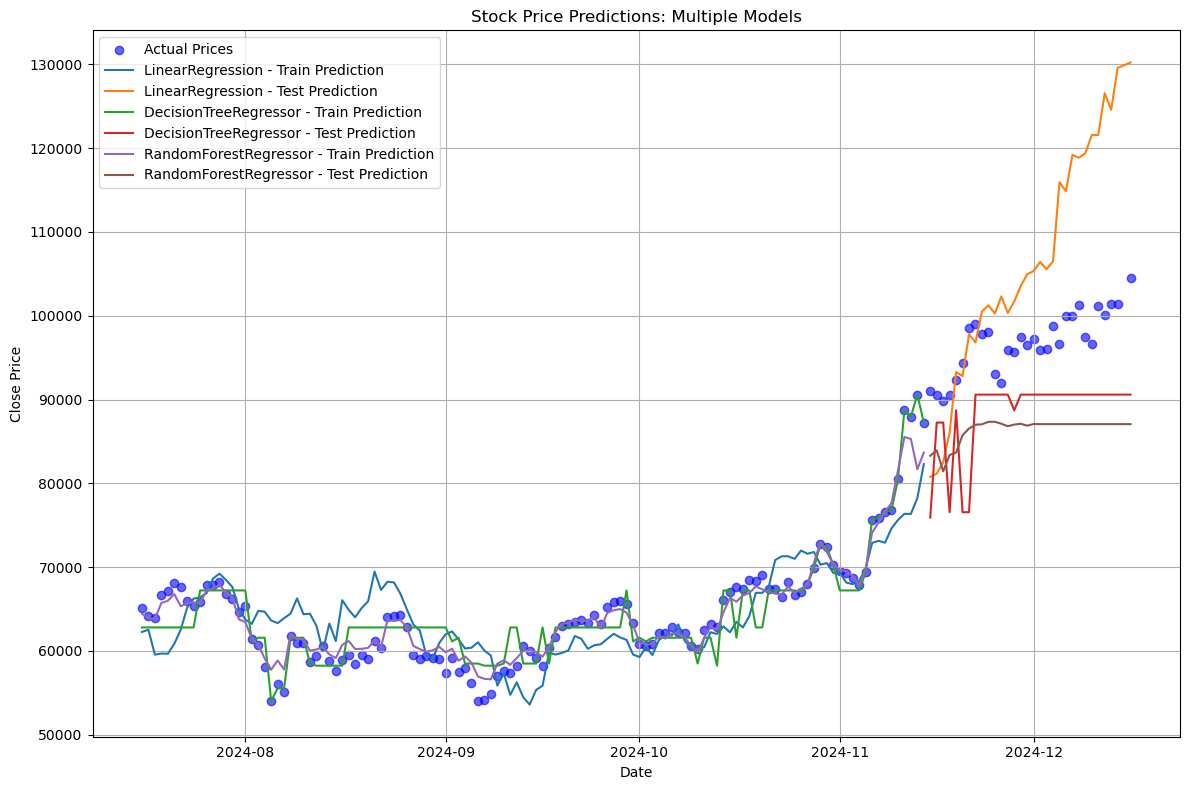

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
# Plot actual prices
plt.scatter(date_df, y, label=f'Actual Prices', color='blue', alpha=0.6)
# Iterate over models and their results
for model_name, model_result in model_results.items():
    if model_name != 'SVR':
        y_pred_train = model_training_predictions.get(model_name, [0] * split_index)  
        y_pred_test = model_predictions.get(model_name, [0] * (len(date_df) - split_index))  
        # Plot train predictions
        plt.plot(date_df[:split_index], y_pred_train, label=f'{model_name} - Train Prediction')
        # Plot test predictions
        plt.plot(date_df[split_index:], y_pred_test, label=f'{model_name} - Test Prediction')
        # Add labels and titles
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Predictions: Multiple Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



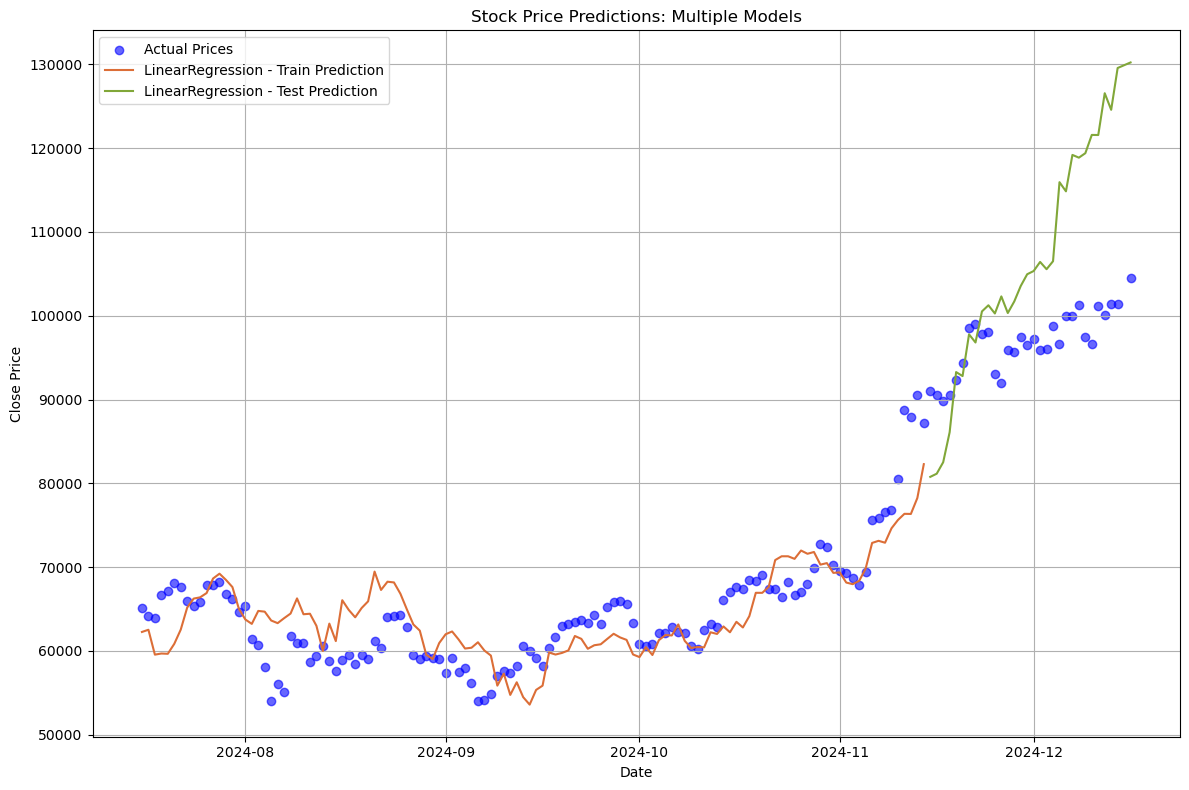

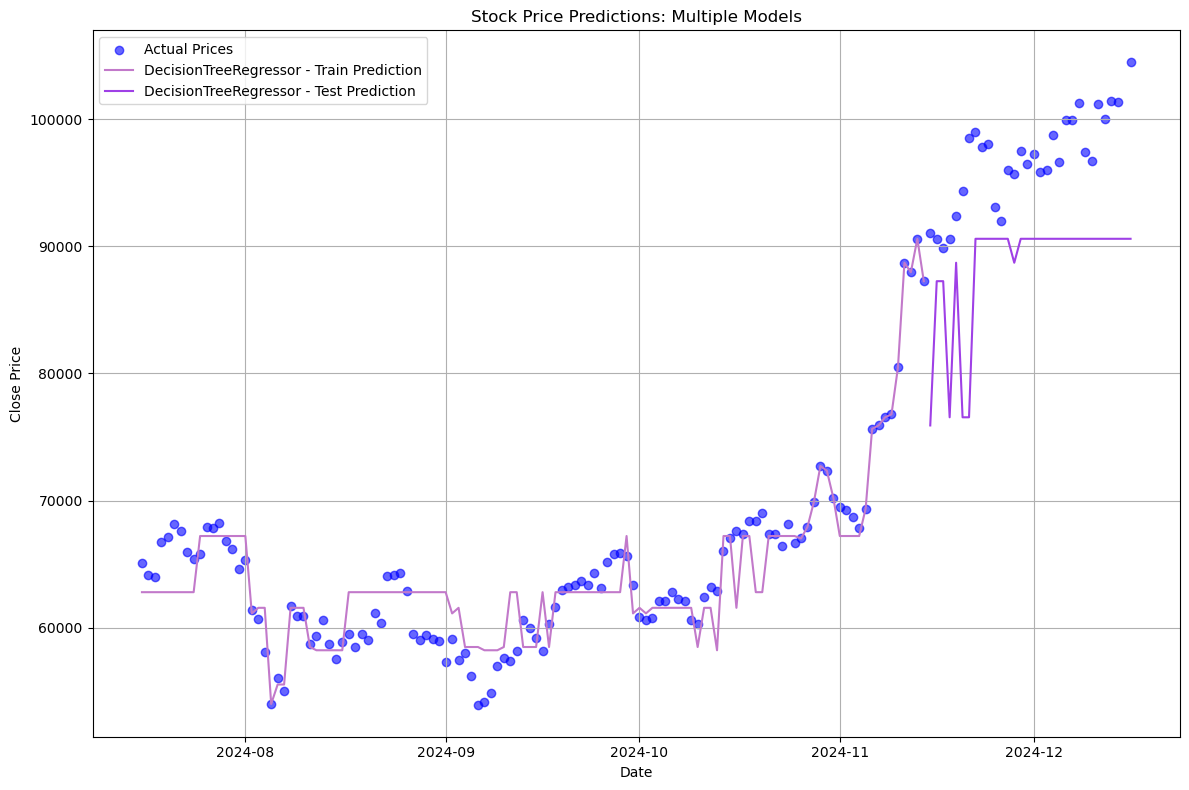

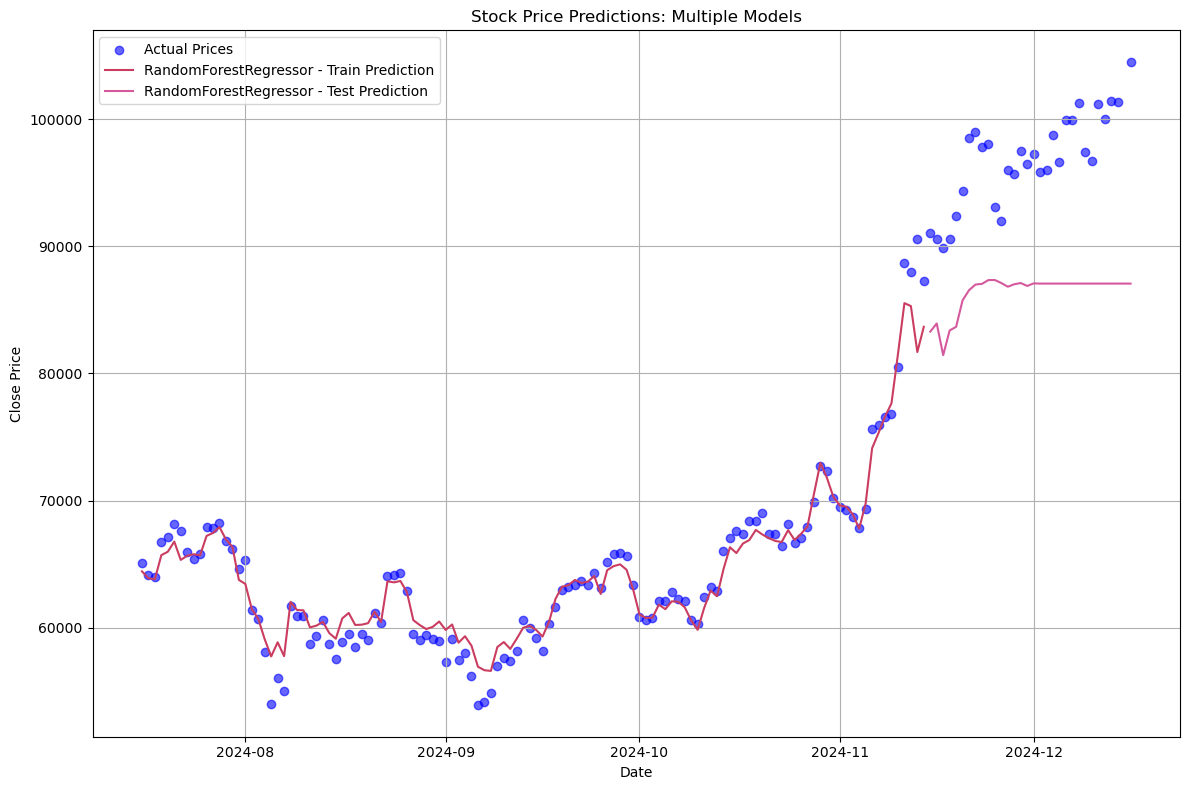

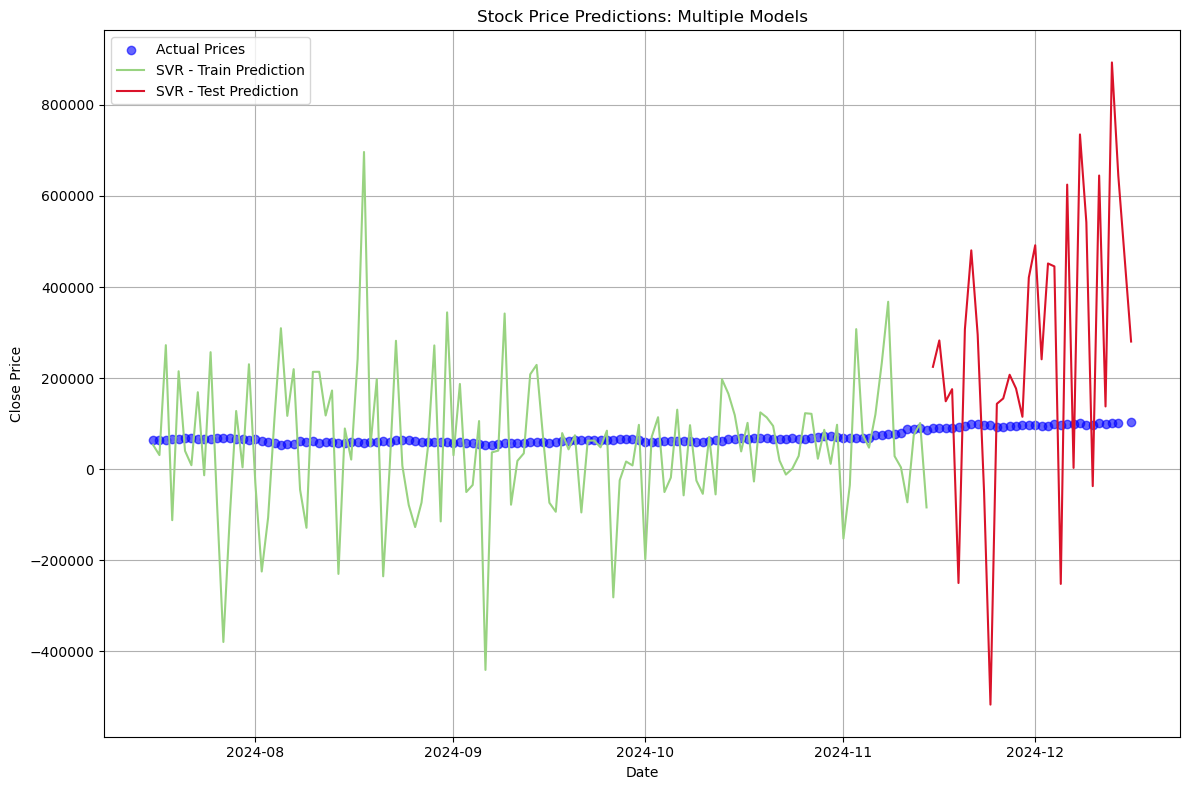

In [13]:
import matplotlib.pyplot as plt
import random

# Generate random color
def random_color():
    return [random.random() for _ in range(3)]  # RGB values between 0 and 1

# Iterate over models and their results
for model_name, model_result in model_results.items():
    if model_name != 'test':
        plt.figure(figsize=(12, 8))
        plt.scatter(date_df, y, label=f'Actual Prices', color='blue', alpha=0.6)
        
        y_pred_train = model_training_predictions.get(model_name, [0] * split_index)  
        y_pred_test = model_predictions.get(model_name, [0] * (len(date_df) - split_index))  
        
        plt.plot(
            date_df[:split_index],
            y_pred_train,
            label=f'{model_name} - Train Prediction',
            color=random_color()
        )
        
        plt.plot(
            date_df[split_index:], 
            y_pred_test, 
            label=f'{model_name} - Test Prediction',
            color=random_color()
        )
        
        # Add labels and titles
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title("Stock Price Predictions: Multiple Models")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Evaluate each model with the predict from train and test prediction

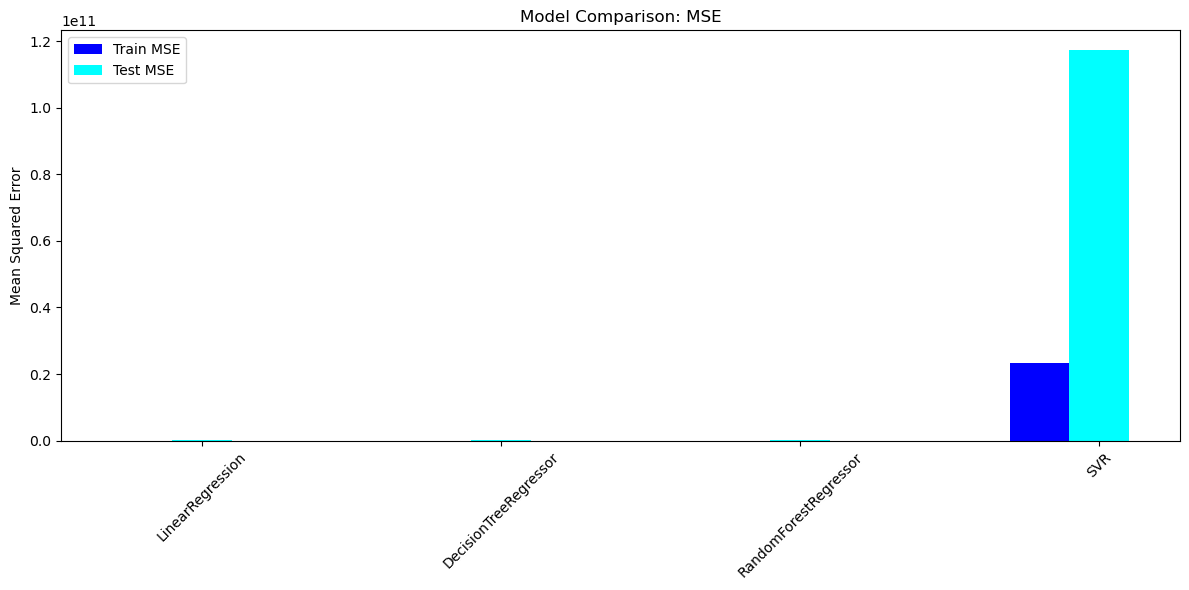

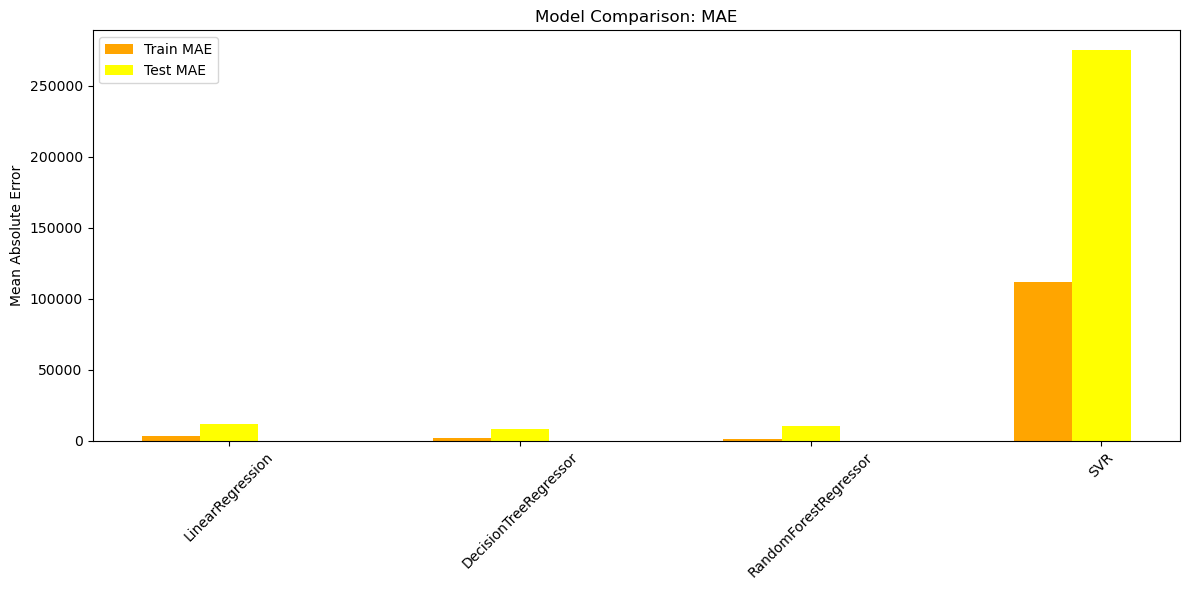

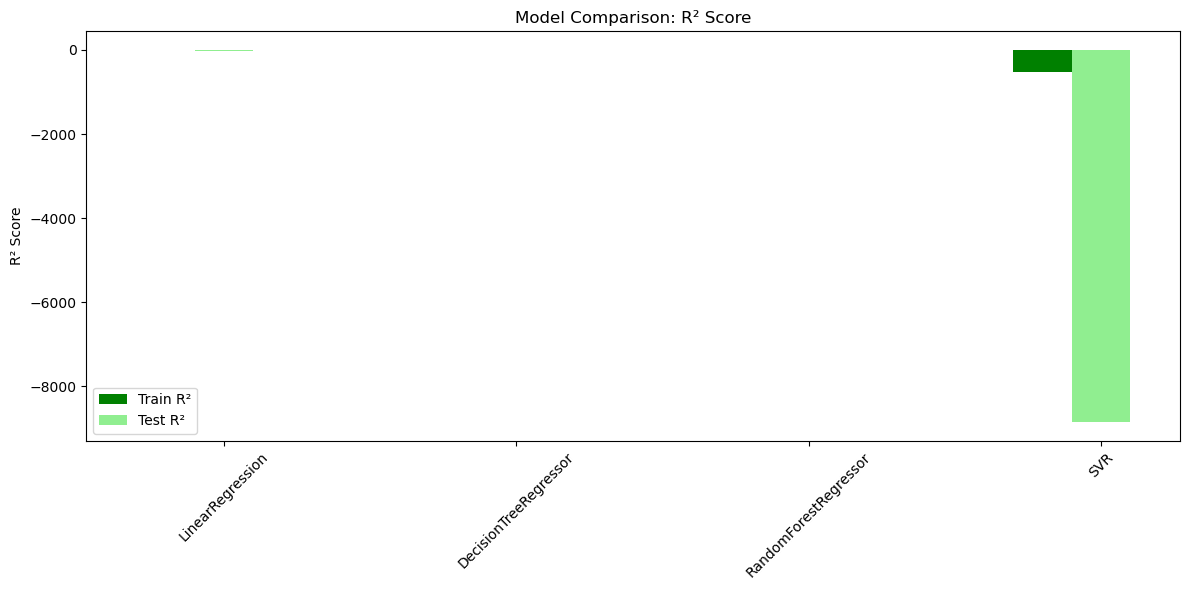


Best Metrics on Training Data:
Best MSE: 2034340.8226 (Model: RandomForestRegressor, Parameters: {'max_depth': 10, 'n_estimators': 50})
Best MAE: 926.9151 (Model: RandomForestRegressor, Parameters: {'max_depth': 10, 'n_estimators': 50})
Best R²: 0.9548 (Model: RandomForestRegressor, Parameters: {'max_depth': 10, 'n_estimators': 50})

Best Metrics on Test Data:
Best MSE: 90522162.3707 (Model: DecisionTreeRegressor, Parameters: {'max_depth': 5})
Best MAE: 8384.5650 (Model: DecisionTreeRegressor, Parameters: {'max_depth': 5})
Best R²: -5.8286 (Model: DecisionTreeRegressor, Parameters: {'max_depth': 5})


In [14]:
import matplotlib.pyplot as plt
import tabulate

# Dictionary to store comparison results
comparison_results = []
best_mse_train = float('inf')
best_mae_train = float('inf')
best_r2_train = -float('inf')
best_mse_test = float('inf')
best_mae_test = float('inf')
best_r2_test = -float('inf')
best_mse_model_train = None
best_mae_model_train = None
best_r2_model_train = None
best_mse_model_test = None
best_mae_model_test = None
best_r2_model_test = None

# Iterate over all models to calculate metrics for both training and testing
for model_name in model_predictions.keys():
    train_predictions = model_training_predictions[model_name]
    test_predictions = model_predictions[model_name]
    
    # Calculate metrics for training and testing predictions
    train_mse = mean_squared_error(y_train, train_predictions)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    # Update the best metrics for training and testing
    if train_mse < best_mse_train:
        best_mse_train = train_mse
        best_mse_model_train = model_name
    if train_mae < best_mae_train:
        best_mae_train = train_mae
        best_mae_model_train = model_name
    if train_r2 > best_r2_train:
        best_r2_train = train_r2
        best_r2_model_train = model_name
    if test_mse < best_mse_test:
        best_mse_test = test_mse
        best_mse_model_test = model_name
    if test_mae < best_mae_test:
        best_mae_test = test_mae
        best_mae_model_test = model_name
    if test_r2 > best_r2_test:
        best_r2_test = test_r2
        best_r2_model_test = model_name
    
    # Append results for the table
    comparison_results.append([
        model_name,
        model_results[model_name]['Best Parameters'],
        train_mse, train_mae, train_r2,
        test_mse, test_mae, test_r2
    ])

# Print the comparison results as a table
headers = [
    "Model", "Best Parameters",
    "Train MSE", "Train MAE", "Train R²",
    "Test MSE", "Test MAE", "Test R²"
]
# print(tabulate(comparison_results, headers=headers, tablefmt="grid"))
# Extract metrics for visualization
models = [result[0] for result in comparison_results]
train_mse = [float(result[2]) for result in comparison_results]
train_mae = [float(result[3]) for result in comparison_results]
train_r2 = [float(result[4]) for result in comparison_results]
test_mse = [float(result[5]) for result in comparison_results]
test_mae = [float(result[6]) for result in comparison_results]
test_r2 = [float(result[7]) for result in comparison_results]

# Bar width for grouped bar chart
bar_width = 0.2
indices = np.arange(len(models))

# Plot MSE comparison
plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width, train_mse, bar_width, label='Train MSE', color='blue')
plt.bar(indices, test_mse, bar_width, label='Test MSE', color='cyan')
plt.xticks(indices, models, rotation=45)
plt.ylabel('Mean Squared Error')
plt.title('Model Comparison: MSE')
plt.legend()
plt.tight_layout()
plt.show()

# Plot MAE comparison
plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width, train_mae, bar_width, label='Train MAE', color='orange')
plt.bar(indices, test_mae, bar_width, label='Test MAE', color='yellow')
plt.xticks(indices, models, rotation=45)
plt.ylabel('Mean Absolute Error')
plt.title('Model Comparison: MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width, train_r2, bar_width, label='Train R²', color='green')
plt.bar(indices, test_r2, bar_width, label='Test R²', color='lightgreen')
plt.xticks(indices, models, rotation=45)
plt.ylabel('R² Score')
plt.title('Model Comparison: R² Score')
plt.legend()
plt.tight_layout()
plt.show()

# Print the best metrics along with their parameters
print("\nBest Metrics on Training Data:")
print(f"Best MSE: {best_mse_train:.4f} (Model: {best_mse_model_train}, Parameters: {model_results[best_mse_model_train]['Best Parameters']})")
print(f"Best MAE: {best_mae_train:.4f} (Model: {best_mae_model_train}, Parameters: {model_results[best_mae_model_train]['Best Parameters']})")
print(f"Best R²: {best_r2_train:.4f} (Model: {best_r2_model_train}, Parameters: {model_results[best_r2_model_train]['Best Parameters']})")

print("\nBest Metrics on Test Data:")
print(f"Best MSE: {best_mse_test:.4f} (Model: {best_mse_model_test}, Parameters: {model_results[best_mse_model_test]['Best Parameters']})")
print(f"Best MAE: {best_mae_test:.4f} (Model: {best_mae_model_test}, Parameters: {model_results[best_mae_model_test]['Best Parameters']})")
print(f"Best R²: {best_r2_test:.4f} (Model: {best_r2_model_test}, Parameters: {model_results[best_r2_model_test]['Best Parameters']})")


In [15]:
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize comparison results list
comparison_results = []

# Calculate metrics for training and testing predictions
for model_name, predictions in model_predictions.items():
    # Training predictions
    train_predictions = model_training_predictions[model_name]
    train_mse = mean_squared_error(y_train, train_predictions)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    # Testing predictions
    test_mse = mean_squared_error(y_test, predictions)
    test_mae = mean_absolute_error(y_test, predictions)
    test_r2 = r2_score(y_test, predictions)

    # Append the row of results to the comparison table
    comparison_results.append([
        model_name,
        model_results[model_name]['Best Parameters'],
        f"{train_mse:.4f}", f"{train_mae:.4f}", f"{train_r2:.4f}",
        f"{test_mse:.4f}", f"{test_mae:.4f}", f"{test_r2:.4f}"
    ])

# Define the table headers
headers = [
    "Model",
    "Best Parameters",
    "Train MSE", "Train MAE", "Train R²",
    "Test MSE", "Test MAE", "Test R²"
]

# Display the comparison results table
print(tabulate(comparison_results, headers=headers, tablefmt="grid"))


+-----------------------+---------------------------------------+-------------+-------------+------------+-------------+------------+------------+
| Model                 | Best Parameters                       |   Train MSE |   Train MAE |   Train R² |    Test MSE |   Test MAE |    Test R² |
+=======================+=======================================+=============+=============+============+=============+============+============+
| LinearRegression      | {}                                    | 1.80034e+07 |    3374.97  |     0.6004 | 2.07847e+08 |   11721.8  |   -14.6791 |
+-----------------------+---------------------------------------+-------------+-------------+------------+-------------+------------+------------+
| DecisionTreeRegressor | {'max_depth': 5}                      | 5.46326e+06 |    1676.66  |     0.8787 | 9.05222e+07 |    8384.57 |    -5.8286 |
+-----------------------+---------------------------------------+-------------+-------------+------------+------------

Lstm Time Series

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [17]:
date_df = lag_df.index
lag_df

,Close,Close_lag1d,Close_lag2d,Close_lag3d,Close_lag4d,Close_lag5d,Close_lag6d,Close_lag7d,Close_lag8d,Close_lag9d,...,Close_lag21d,Close_lag22d,Close_lag23d,Close_lag24d,Close_lag25d,Close_lag26d,Close_lag27d,Close_lag28d,Close_lag29d,Close_lag30d
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-16 00:00:00+00:00,65097.148438,64870.152344,60787.792969,59231.953125,57899.464844,57344.914062,57742.496094,58009.226562,56705.097656,55849.109375,...,61804.640625,60277.414062,63180.796875,64252.578125,64096.199219,64828.656250,64960.296875,65140.746094,66490.296875,66639.046875
2024-07-17 00:00:00+00:00,64118.792969,65097.148438,64870.152344,60787.792969,59231.953125,57899.464844,57344.914062,57742.496094,58009.226562,56705.097656,...,60811.277344,61804.640625,60277.414062,63180.796875,64252.578125,64096.199219,64828.656250,64960.296875,65140.746094,66490.296875
2024-07-18 00:00:00+00:00,63974.066406,64118.792969,65097.148438,64870.152344,60787.792969,59231.953125,57899.464844,57344.914062,57742.496094,58009.226562,...,61604.800781,60811.277344,61804.640625,60277.414062,63180.796875,64252.578125,64096.199219,64828.656250,64960.296875,65140.746094
2024-07-19 00:00:00+00:00,66710.156250,63974.066406,64118.792969,65097.148438,64870.152344,60787.792969,59231.953125,57899.464844,57344.914062,57742.496094,...,60320.136719,61604.800781,60811.277344,61804.640625,60277.414062,63180.796875,64252.578125,64096.199219,64828.656250,64960.296875
2024-07-20 00:00:00+00:00,67163.648438,66710.156250,63974.066406,64118.792969,65097.148438,64870.152344,60787.792969,59231.953125,57899.464844,57344.914062,...,60887.378906,60320.136719,61604.800781,60811.277344,61804.640625,60277.414062,63180.796875,64252.578125,64096.199219,64828.656250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-11 00:00:00+00:00,101173.031250,96675.429688,97432.718750,101236.015625,99923.335938,99920.710938,96593.570312,98768.531250,96002.164062,95865.304688,...,94339.492188,92343.789062,90542.640625,89845.851562,90558.476562,91066.007812,87250.429688,90584.164062,87955.812500,88701.484375
2024-12-12 00:00:00+00:00,100043.000000,101173.031250,96675.429688,97432.718750,101236.015625,99923.335938,99920.710938,96593.570312,98768.531250,96002.164062,...,98504.726562,94339.492188,92343.789062,90542.640625,89845.851562,90558.476562,91066.007812,87250.429688,90584.164062,87955.812500
2024-12-13 00:00:00+00:00,101459.257812,100043.000000,101173.031250,96675.429688,97432.718750,101236.015625,99923.335938,99920.710938,96593.570312,98768.531250,...,98997.664062,98504.726562,94339.492188,92343.789062,90542.640625,89845.851562,90558.476562,91066.007812,87250.429688,90584.164062


In [18]:
def windowed_df_to_date_X_y(windowed_dataframe,number_of_timestamp):
  df_as_np = windowed_dataframe.to_numpy()

  dates = windowed_dataframe.index.to_numpy()

  middle_matrix = df_as_np[:, 1:number_of_timestamp+1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, 0]

  return dates, X.astype(np.float32), Y.astype(np.float32)

number_of_timestamp = 5
dates, X, y = windowed_df_to_date_X_y(lag_df,number_of_timestamp)

dates.shape, X.shape, y.shape
# dates

((153,), (153, 5, 1), (153,))

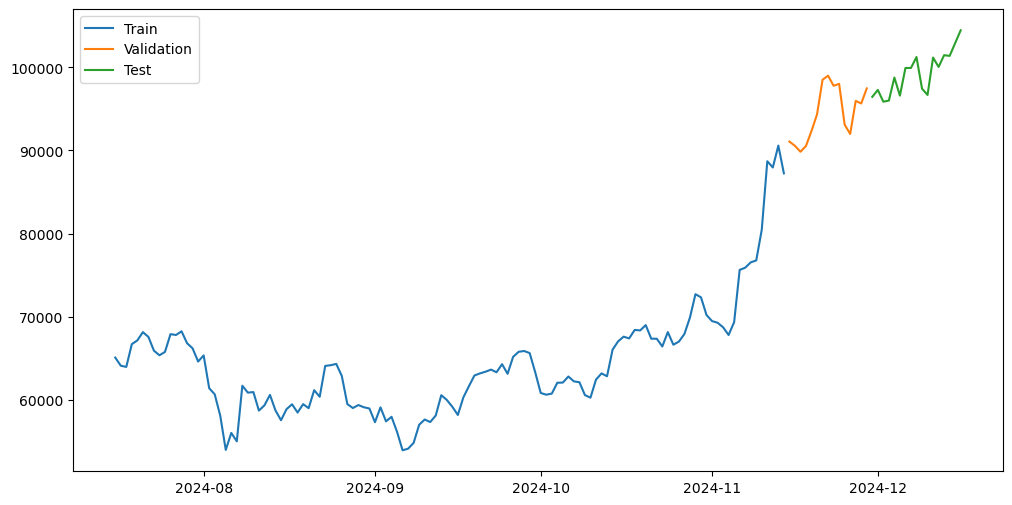

In [19]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [20]:
from tensorflow.keras.models import Sequential

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(number_of_timestamp, 1)),  # First LSTM layer
    LSTM(50, activation='relu', return_sequences=True),  # Second LSTM layer
    LSTM(50, activation='relu'),  # Third LSTM layer 
    Dense(1)  # Output layer
])

# Compile model with MSE as loss and MAE as a metric
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/150
4/4 [==============================] - 3s 138ms/step - loss: 4201235456.0000 - mae: 64472.4258 - val_loss: 8679915520.0000 - val_mae: 93113.2422
Epoch 2/150
4/4 [==============================] - 0s 12ms/step - loss: 4120503552.0000 - mae: 63846.2188 - val_loss: 8941059072.0000 - val_mae: 94501.1328
Epoch 3/150
4/4 [==============================] - 0s 12ms/step - loss: 4174138368.0000 - mae: 64253.1172 - val_loss: 8759514112.0000 - val_mae: 93539.5312
Epoch 4/150
4/4 [==============================] - 0s 12ms/step - loss: 4082422272.0000 - mae: 63545.6133 - val_loss: 8593434624.0000 - val_mae: 92648.2188
Epoch 5/150
4/4 [==============================] - 0s 11ms/step - loss: 4071475200.0000 - mae: 63456.6562 - val_loss: 8504009216.0000 - val_mae: 92157.9453
Epoch 6/150
4/4 [==============================] - 0s 12ms/step - loss: 3908588288.0000 - mae: 62168.5898 - val_loss: 8151300096.0000 - val_mae: 90232.0703
Epoch 7/150
4/4 [==============================] - 0s 12ms/step

1/1 [==============================] - 0s 16ms/step


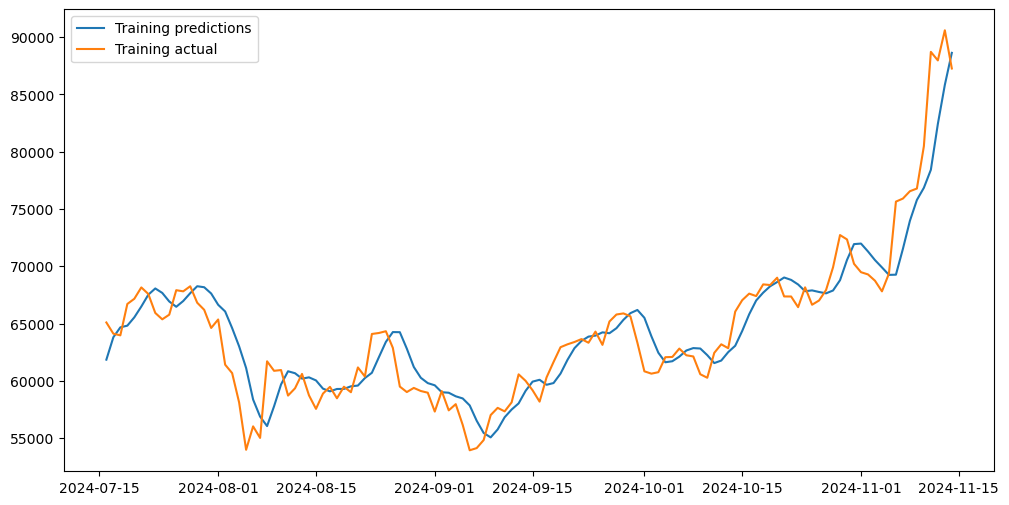

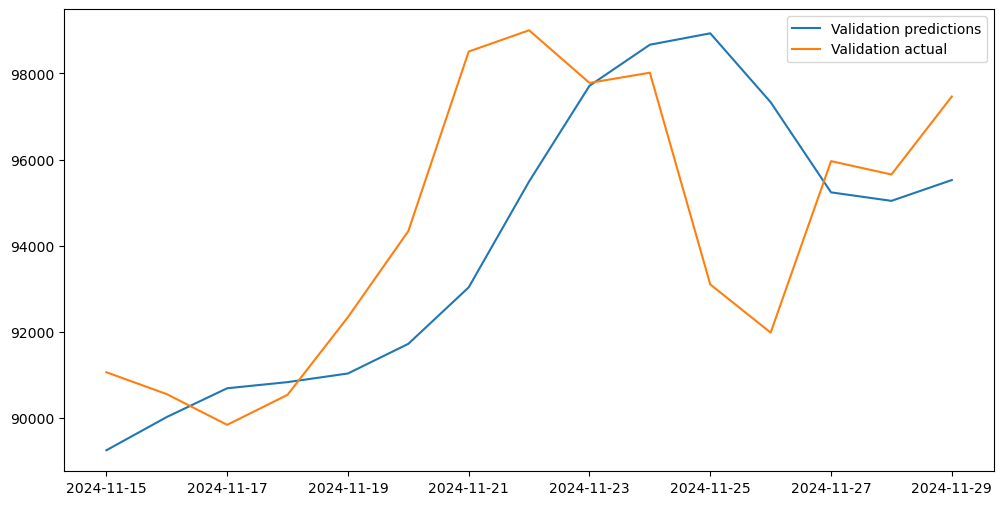

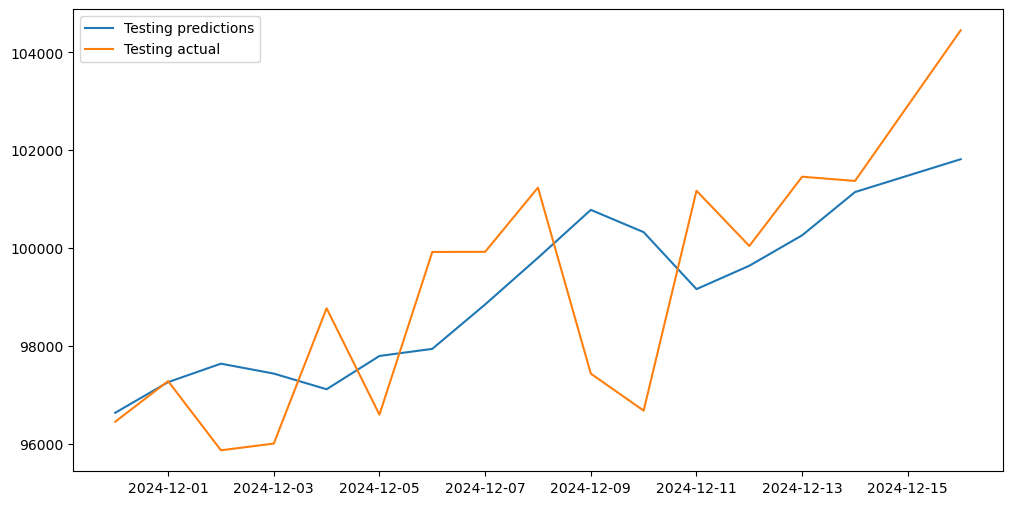

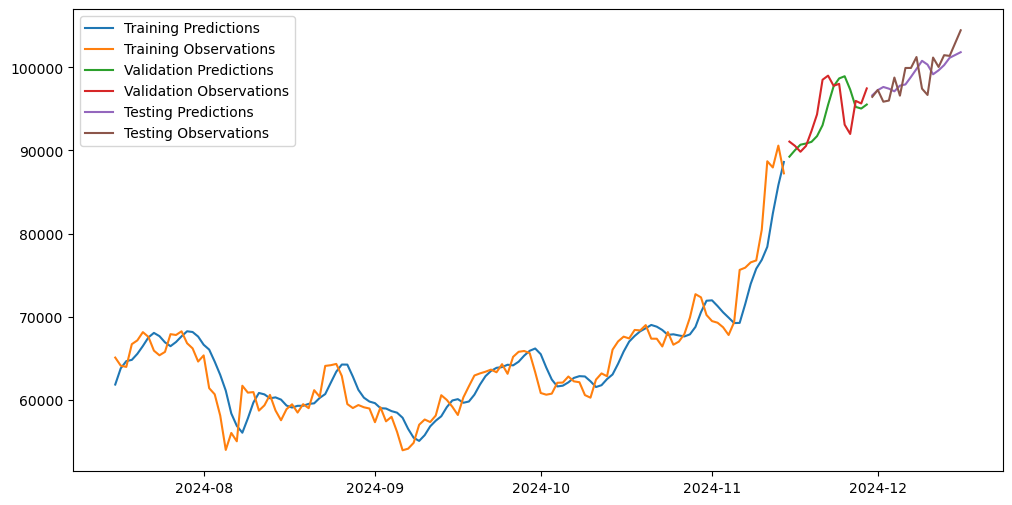

In [21]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training predictions', 'Training actual'])

val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(12, 6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation predictions', 'Validation actual'])

test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(12, 6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing predictions', 'Testing actual'])

plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

1/1 [==============================] - 0s 23ms/step - loss: 3358300.0000 - mae: 1514.5254
Test MSE: 3358300.0
Test MAE: 1514.525390625
1/1 [==============================] - 0s 19ms/step
Test R²: 0.4396368890657768


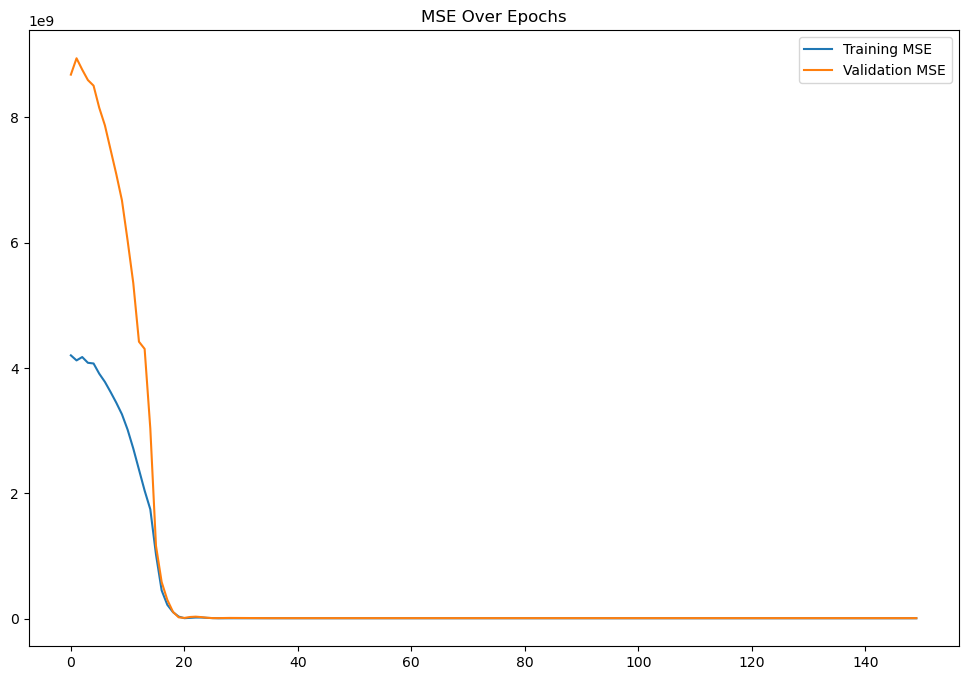

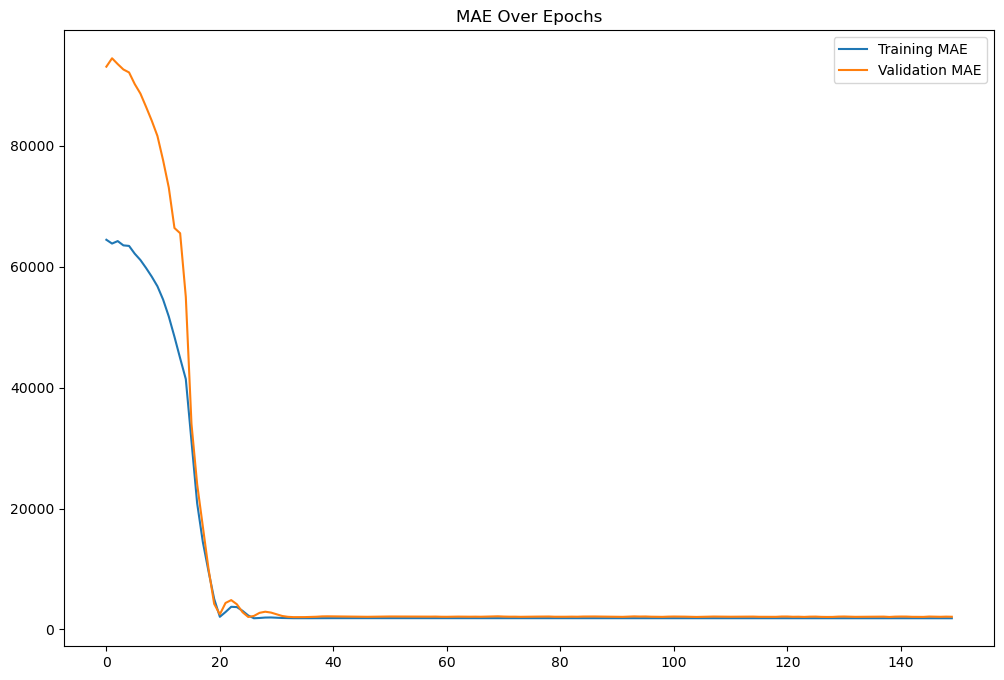

In [22]:
from sklearn.metrics import r2_score

# Evaluate on test data
results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MSE: {results[0]}")
print(f"Test MAE: {results[1]}")

# Predict and calculate R²
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Test R²: {r2}")

# Plot metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.legend()
plt.title('MSE Over Epochs')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.title('MAE Over Epochs')
plt.show()
